# Exercise 6b - Advanced segmentation. Fisherman's Linear discriminant analysis for segmentation

## Imports and functions

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.io as sio
from skimage.morphology import opening, closing
from skimage.morphology import disk
from LDA import LDA

## Lecture exercises

### Exercise 1 - Hough space
If we select $\theta$ to 60 degree what is r when the point is (x,y)=(201.5, 348.9)?
- Hough space: $r = x cos \theta + y sin \theta$

In [193]:
# Convert degrees to radians (math.radians(degrees))
# Convert radians to degrees (math.degrees(radians))
theta = 60
x, y = 201.5, 348.9

x*np.cos(math.radians(theta)) + y*np.sin(math.radians(theta))

402.90626338039067

## Image Segmentation

In [175]:
in_dir = 'data/'
in_file = 'ex6_ImagData2Load.mat'
data = sio.loadmat(in_dir + in_file)
ImgT1 = data['ImgT1']
ImgT2 = data['ImgT2']
ROI_GM = data['ROI_GM'].astype(bool)
ROI_WM = data['ROI_WM'].astype(bool)

### Exercise 1 
Display both the T1 and T2 images, their 1 and 2D histograms and scatter plots. 

![imshow image coordinates](figs/Picture1.png)

The two MRI image modalities contain different types of intensity classes:

1. (Orange): The White Matter (WM) is the tissue type that contain the brain network - like the cables in the internet. The  WM ensure the communication flow between functional brain regions.
2. (Yellow): The Grey Matter (GM) is the tissue type that contain the cell bodies at the end of the brain network and are the functional units in the brain. The functional units are like CPUs in the computer. They are processing our sensorial input and are determining a reacting to these. It could be to start running.
3. (Magenta): Cerebrospinal fluid (CSF) which is the water in the brain 
4. (Green): Background of the image


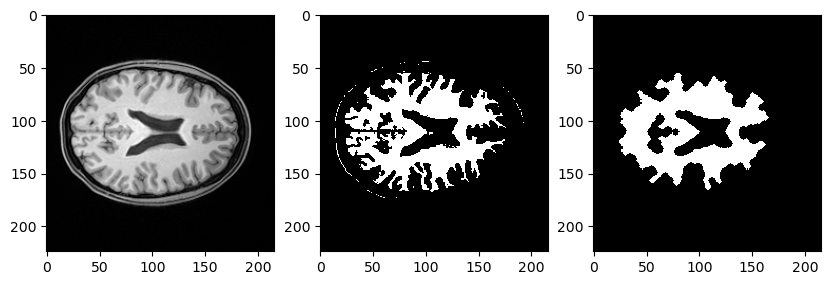

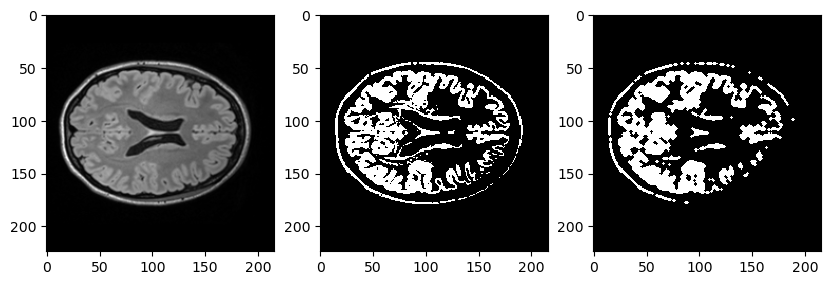

In [176]:
# T1
mask_init = ImgT1 > 500
mask = opening(mask_init, disk(2))
mask_T1 = closing(mask, disk(3))
T1_values = ImgT1[mask_T1]

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10))
axs[0].imshow(ImgT1, cmap = 'gray')
axs[1].imshow(mask_init, cmap = 'gray', interpolation = 'none')
axs[2].imshow(mask_T1, cmap = 'gray', interpolation = 'none')
plt.show()

# T2
mask_init = ImgT2 > 165
mask = opening(mask_init, disk(1))
mask_T2 = closing(mask, disk(1))
T2_values = ImgT2[mask_T2]

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10))
axs[0].imshow(ImgT2, cmap = 'gray')
axs[1].imshow(mask_init, cmap = 'gray', interpolation = 'none')
axs[2].imshow(mask_T2, cmap = 'gray', interpolation = 'none')
plt.show()


**Q1**: What is the intensity threshold that can separate the GM and WM classes (roughly) from the 1D histograms? 
500 for T1 and 155 for T2 seems like a good fit

**Q2**: Can the GM and WM intensity classes be observed in the 2D histogram and scatter plot?


In [177]:
def my_show_1D_histogram(img, mask, img_name, axs):
    axs[0].imshow(img, cmap = 'gray')
    axs[0].set_title(img_name)
    axs[0].set_axis_off()

    intensities = img[mask]
    axs[1].hist(intensities, bins = 100)
    axs[1].set_title(f'1D Histogram {img_name}')
    axs[1].set_xlabel('Intensities')
    axs[1].set_ylabel('Frequency')

    return intensities

In [184]:
def plot_histograms(img1, img2, title1='img1', title2='img2',range= None, bins=50):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    axs[0].hist(img1.ravel(), range=range,bins=bins)
    axs[0].set_title(title1)

    axs[1].hist(img2.ravel(), range=range, bins=bins)
    axs[1].set_title(title2)

    plt.show()

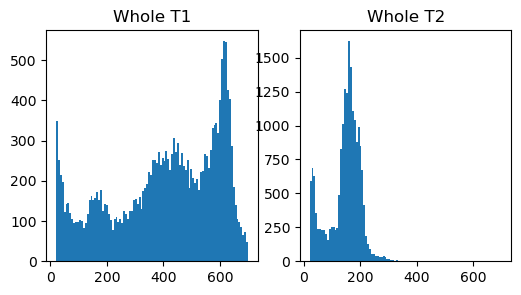

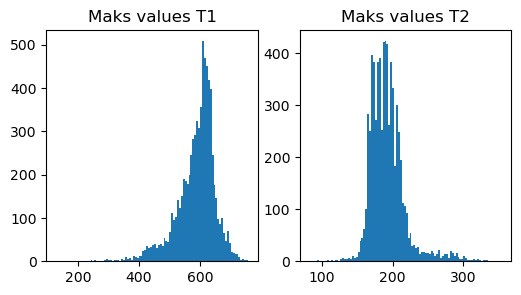

In [185]:
plot_histograms(ImgT1, ImgT2, 'Whole T1', 'Whole T2', (20,700), bins=100)
plot_histograms(T1_values, T2_values, 'Maks values T1', 'Maks values T2', bins=100)

In [164]:
'''
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8))
T1_intensities = my_show_1D_histogram(ImgT1, mask_T1, 'T1w image', axs[0, 0:2])
T2_intensities = my_show_1D_histogram(ImgT2, mask_T2, 'T2w image', axs[1, 0:2])
axs[0,2].hist2d(T1_intensities, T2_intensities, bins = 100)
axs[0,2].set_xlabel('T1w intensities')
axs[0,2].set_ylabel('T2w intensities')
axs[0,2].set_title('2D histogram')

axs[1,2].scatter(T1_intensities, T2_intensities)
axs[1,2].set_xlabel('T1w intensities')
axs[1,2].set_ylabel('T2w intensities')
axs[1,2].set_title('Scatter plot')
plt.tight_layout()
plt.show()
'''

"\nfig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8))\nT1_intensities = my_show_1D_histogram(ImgT1, mask_T1, 'T1w image', axs[0, 0:2])\nT2_intensities = my_show_1D_histogram(ImgT2, mask_T2, 'T2w image', axs[1, 0:2])\naxs[0,2].hist2d(T1_intensities, T2_intensities, bins = 100)\naxs[0,2].set_xlabel('T1w intensities')\naxs[0,2].set_ylabel('T2w intensities')\naxs[0,2].set_title('2D histogram')\n\naxs[1,2].scatter(T1_intensities, T2_intensities)\naxs[1,2].set_xlabel('T1w intensities')\naxs[1,2].set_ylabel('T2w intensities')\naxs[1,2].set_title('Scatter plot')\nplt.tight_layout()\nplt.show()\n"

### Exercise 2 - Show training
Place trainings examples i.e. ROI_WM and ROI_GM into variables C1 and C2 representing class 1 and class 2 respectively. Show in a figure the manually expert drawings of the C1 and C2 training examples.

Q3: Does the ROI drawings look like what you expect from an expert?

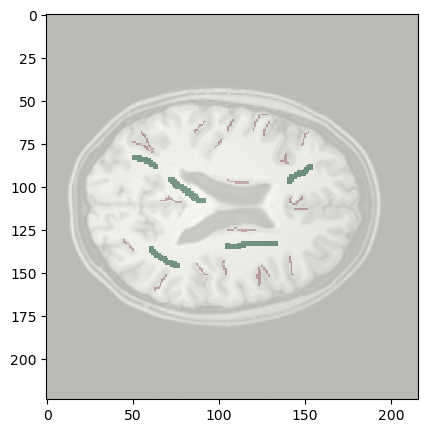

In [167]:
C1 = ROI_GM
C2 = ROI_WM

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
axs.imshow(ImgT1, cmap = 'gray')
axs.imshow(C1, cmap = 'Reds', alpha = 0.5, interpolation = 'none')
axs.imshow(C2, cmap = 'Greens', alpha = 0.5, interpolation = 'none')
plt.show()

### Exercise 3 - Seperate based on training
For each binary training ROI find the corresponding training examples in ImgT1 and ImgT2. Later these will be extracted for LDA training.

Q4: What is the difference between the 1D histogram of the training examples and the 1D histogram of the whole image? Is the difference expected?

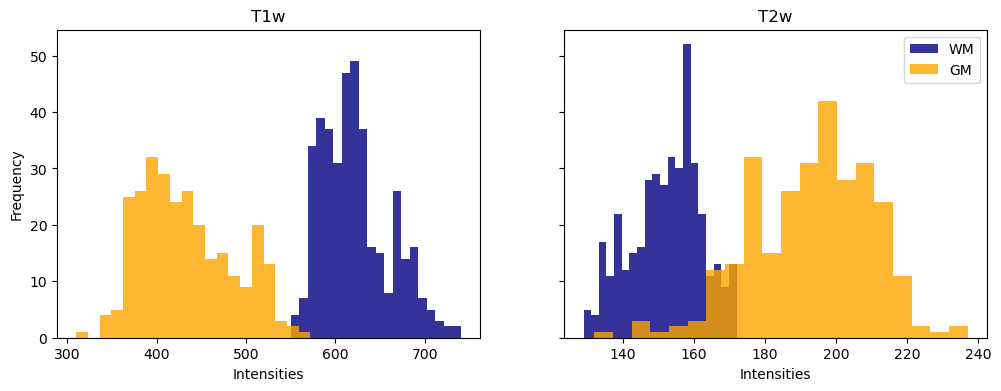

In [169]:
trainWM_T1 = ImgT1[ROI_WM] # trainWM_T1 = ImgT1[qC1[:,0], qC1[:,1]]
trainGM_T1 = ImgT1[ROI_GM] # trainGM_T1 = ImgT1[qC2[:,0], qC2[:,1]]

trainWM_T2 = ImgT2[ROI_WM] # trainWM_T2 = ImgT2[qC1[:,0], qC1[:,1]]
trainGM_T2 = ImgT2[ROI_GM] # trainGM_T2 = ImgT2[qC2[:,0], qC2[:,1]]

fig, axs = plt.subplots(1, 2, figsize = (12, 4), sharex = False, sharey = True)
axs[0].hist(trainWM_T1, bins=20, color = 'navy', label = 'WM', alpha = 0.8)
axs[0].hist(trainGM_T1, bins=20, color = 'orange', label = 'GM', alpha = 0.8)
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Intensities')
axs[0].set_title('T1w')

axs[1].hist(trainWM_T2, bins=20, color = 'navy', label = 'WM', alpha = 0.8)
axs[1].hist(trainGM_T2, bins=20, color = 'orange', label = 'GM', alpha = 0.8)
axs[1].set_xlabel('Intensities')
axs[1].set_title('T2w')
plt.legend()
plt.show()


### Exercise 4
Make a training data vector (X) and target class vector (T) as input for the LDA() function. T and X should have the same length of data points.

X: Training data vector should first include all data points for class 1 and then the data points for class 2. Data points are the two input features ImgT1, ImgT2

T: Target class identifier for X where '0' are Class 1 and a '1' is Class 2.

In [172]:
mask_init = ImgT2 > 165
X = np.matrix([[ImgT1[ROI_WM], ImgT1[ROI_GM]], [ImgT2[ROI_WM], ImgT2[ROI_GM]]])
T = [ROI_GM, ROI_WM]
LDA(X, T)

ValueError: matrix must be 2-dimensional